<a href="https://colab.research.google.com/github/rusetskiy1974/Data-Sciens/blob/main/HW10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Частина 1

Дану нейромережу ми будемо вивчати на датасеті Fashion-MNIST. Fashion-MNIST - це набір даних зображень статей Заландо, що складається з навчального набору з 60 000 прикладів і тестового набору з 10 000 прикладів. Кожен приклад є зображення у відтінках сірого розміром 28x28, пов'язане з міткою з 10 класів. Кожен піксель приймає значення від 0 до 255.

In [28]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


# Завантажуємо датасет

In [29]:
# from tensorflow.keras.datasets import mnist
from keras.datasets import fashion_mnist

# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

Нормалізуємо дані

In [30]:
x_train = x_train.reshape((60000, 28, 28, 1))
x_train = x_train.astype("float32") / 255
x_test = x_test.reshape((10000, 28, 28, 1))
x_test = x_test.astype("float32") / 255


One-hot encoding — це техніка, яка перетворює категорійні змінні у вигляді чисел у вектори, де кожному класу відповідає вектор, який містить одиницю в позиції, що відповідає цьому класу, і нулі в усіх інших позиціях.Наприклад, у випадку датасету Fashion MNIST, де є 10 класів (від 0 до 9, де кожен клас відповідає певному типу одягу):

    Клас 0 може бути закодований як [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    Клас 1 може бути закодований як [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
    І так далі до класу 9: [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]

Коли категорійні мітки перетворюються в числовий формат, такі числа можуть сприйматися моделлю як порядкові (мають певний порядок). Наприклад, мітки 0, 1, 2 можуть бути сприйняті як такі, що мають порядкові відносини, що є некоректним для багатьох задач класифікації. One-hot encoding усуває цю проблему, представляючи мітки у вигляді бінарних векторів.

In [31]:
from tensorflow.keras.utils import to_categorical

In [32]:
# One-hot encoding для міток
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [33]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((60000, 28, 28, 1), (60000, 10), (10000, 28, 28, 1), (10000, 10))

# Використання Keras Tuner для автоматичного налаштування гіперпараметрів є відмінним підходом. Keras Tuner дозволяє автоматизувати процес пошуку найкращих гіперпараметрів для   моделі нейронної мережі.

In [34]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 11.3 MB/s eta 0:00:00


# Функція візуалізації

In [35]:
def plot_training_history(history, title):
    plt.figure(figsize=(12, 4))

    # Точність
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Втрата
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.suptitle(title)
    plt.show()

In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.utils import to_categorical
from keras_tuner.tuners import RandomSearch
from tensorflow.keras import regularizers

Функція build_model створює та компілює модель нейронної мережі за допомогою бібліотеки Keras, використовуючи параметри, які надаються гіперпараметричним пошуком.

Функція build_model використовує гіперпараметри для налаштування різних аспектів моделі нейронної мережі. Використання об'єкта hp (HyperParameters) дозволяє здійснювати гіперпараметричний пошук для вибору найкращих параметрів, таких як кількість шарів, кількість нейронів у кожному шарі, функції активації, dropout та оптимізатор. Це забезпечує побудову моделі, яка може бути оптимально налаштована для вирішення задачі класифікації на датасеті Fashion MNIST.

In [37]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D

In [38]:
def build_model(hp):
    # Створюємо послідовну модель, де шари додаються один за іншим.
    model = Sequential()

    # Додаємо згортковий шар з вибором кількості фільтрів і розміру ядра.
    model.add(Conv2D(filters=32,
                      kernel_size=3,
                      activation='relu',
                      input_shape=(28, 28, 1)))
    # Додаємо шар підвибірки (MaxPooling).
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Вибір кількості згорткових шарів між 1 і 2.
    for i in range(hp.Int('num_conv_layers', 1, 2)):
        model.add(Conv2D(filters=hp.Int(f'conv_filters_{i+2}', min_value=64, max_value=128, step=32),
                          kernel_size=hp.Choice(f'conv_kernel_size_{i+2}', values=[3, 5]),
                          activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))

    # Перетворюємо дані на одновимірний вектор.
    model.add(Flatten())

    # Вибір кількості прихованих шарів, яка буде між
    for i in range(hp.Int('num_layers', 1, 1)):
        # Для кожного шару Dense визначає кількість нейронів, яка може бути від 64 до 512 з кроком 64 (тобто 64, 128, 192, ..., 512).
        model.add(Dense(units=64,
                        # Визначаємо функцію активації для кожного шару, вибираючи з переліку
                        activation=hp.Choice('activation_' + str(i),
                                             #values=['relu', 'tanh', 'linear', 'elu', 'swish', 'softplus']))) # Close the parenthesis for activation choice here
                                              values=['relu'])))

    # Додаємо вихідний шар з 10 нейронами (по одному для кожного класу) з функцією активації softmax, яка перетворює виходи на ймовірності класів.
    model.add(Dense(10, activation='softmax'))

    model.compile(
        # Вибір оптимізатора з наданого списку.
        optimizer=hp.Choice('optimizer',
                            #values=['adam', 'adamax', 'nadam', 'rmsprop', 'sgd']),
                            values=['adam', 'rmsprop']),
        # Функція втрат для задачі багатокласової класифікації.
        loss='categorical_crossentropy',
        # Метрика для оцінки моделі під час навчання та тестування.
        metrics=['accuracy'])

    return model



Використаємо Keras Tuner для автоматичного пошуку найкращих гіперпараметрів моделі нейронної мережі на основі датасету Fashion MNIST.

In [39]:
# RandomSearch один з методів пошуку гіперпараметрів у Keras Tuner
tuner = RandomSearch(
    # Наша функція для побудови моделі з використанням гіперпараметрів
    build_model,
    objective='accuracy',
    max_trials=5,  # Кількість різних налаштувань гіперпараметрів для перевірки
    executions_per_trial=1, # Кількість повторень кожного випробування
    directory='my_dir',
    project_name='fashion_mnist')
# Цей рядок виводить зведення про простір гіперпараметрів, що буде використовуватись під час пошуку.
# Це допомагає зрозуміти, які параметри будуть налаштовуватись і які значення вони можуть приймати.
tuner.search_space_summary()

# Виконання пошуку
tuner.search(x_train, y_train,
             epochs=20,
             validation_split=0.2)

# Інформація про найкращі знайдені гіперпараметри, а також про продуктивність відповідних моделей.
tuner.results_summary()

# Отримання найкращої моделі
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()



Trial 5 Complete [00h 03m 24s]
accuracy: 0.9750833511352539

Best accuracy So Far: 0.9807291626930237
Total elapsed time: 00h 14m 27s
Results summary
Results in my_dir/fashion_mnist
Showing 10 best trials
Objective(name="accuracy", direction="max")

Trial 1 summary
Hyperparameters:
num_conv_layers: 1
conv_filters_2: 64
conv_kernel_size_2: 3
num_layers: 1
activation_0: relu
optimizer: adam
conv_filters_3: 128
conv_kernel_size_3: 5
Score: 0.9807291626930237

Trial 3 summary
Hyperparameters:
num_conv_layers: 1
conv_filters_2: 128
conv_kernel_size_2: 3
num_layers: 1
activation_0: relu
optimizer: rmsprop
conv_filters_3: 128
conv_kernel_size_3: 5
Score: 0.9751666784286499

Trial 4 summary
Hyperparameters:
num_conv_layers: 2
conv_filters_2: 64
conv_kernel_size_2: 5
num_layers: 1
activation_0: relu
optimizer: adam
conv_filters_3: 96
conv_kernel_size_3: 3
Score: 0.9750833511352539

Trial 2 summary
Hyperparameters:
num_conv_layers: 1
conv_filters_2: 96
conv_kernel_size_2: 5
num_layers: 1
activat

In [41]:
best_model.save(
"/content/drive/MyDrive/prepared_train_data/models/best_model.hdf5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


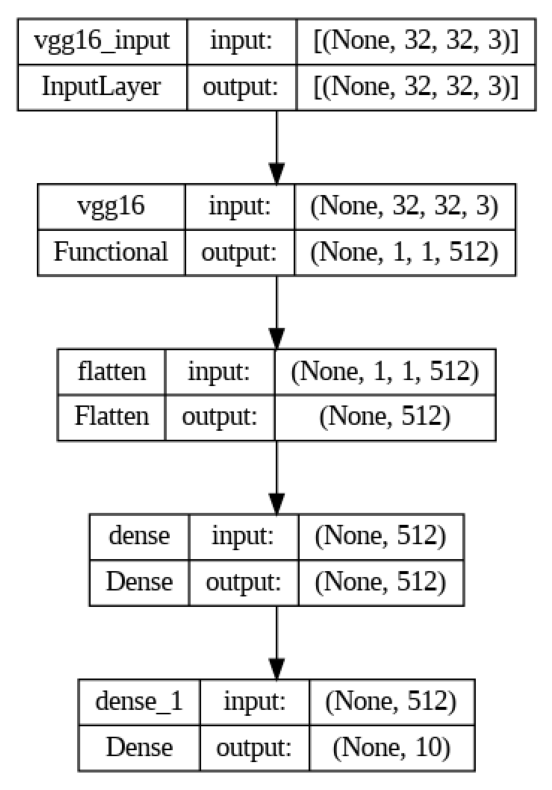

In [40]:
# Візуалізувати модель та зберегти її у файл
plot_model(model, to_file="/content/drive/MyDrive/files/best_model.png", show_shapes=True, show_layer_names=True)

# Завантажити та показати зображення моделі
img = mpimg.imread("/content/drive/MyDrive/files/model.png")
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
from keras.models import load_model
best_model = load_model(
    "/content/drive/MyDrive/prepared_train_data/models/best_model.hdf5")

In [42]:

# Навчання найкращої моделі з історією
best_history = best_model.fit(x_train, y_train,
                              epochs=20,
                              batch_size=64,
                              validation_split=0.2,
                              verbose=1)

Epoch 1/20
750/750 [==============================] - 5s 5ms/step - loss: 0.0226 - accuracy: 0.9927 - val_loss: 0.4234 - val_accuracy: 0.9163
Epoch 2/20
750/750 [==============================] - 3s 5ms/step - loss: 0.0187 - accuracy: 0.9938 - val_loss: 0.4741 - val_accuracy: 0.9123
Epoch 3/20
750/750 [==============================] - 4s 6ms/step - loss: 0.0213 - accuracy: 0.9926 - val_loss: 0.4836 - val_accuracy: 0.9122
Epoch 4/20
750/750 [==============================] - 3s 4ms/step - loss: 0.0204 - accuracy: 0.9934 - val_loss: 0.4987 - val_accuracy: 0.9108
Epoch 5/20
750/750 [==============================] - 3s 4ms/step - loss: 0.0227 - accuracy: 0.9918 - val_loss: 0.6064 - val_accuracy: 0.9050
Epoch 6/20
750/750 [==============================] - 5s 7ms/step - loss: 0.0219 - accuracy: 0.9924 - val_loss: 0.5368 - val_accuracy: 0.9084
Epoch 7/20
750/750 [==============================] - 4s 5ms/step - loss: 0.0219 - accuracy: 0.9921 - val_loss: 0.5261 - val_accuracy: 0.9097
Epoch 

In [57]:
import pickle
# Збереження історії тренування в файл
with open('/content/drive/MyDrive/files/training_history_best_model.pkl', 'wb') as file:
    pickle.dump(best_history.history, file)

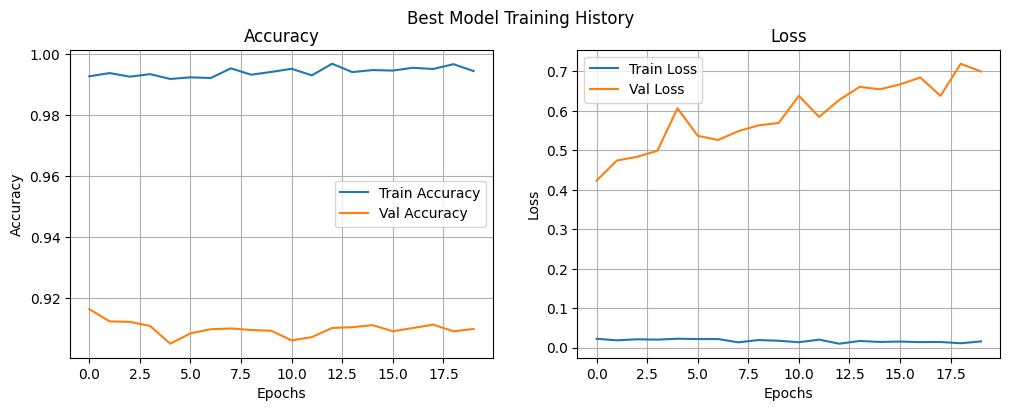

In [44]:
# Візуалізація історії навчання найкращої моделі
plot_training_history(best_history, title='Best Model Training History')

In [47]:
# Оцінка моделі
test_loss, test_acc = best_model.evaluate(x_test, y_test, verbose=0)
print(f'Best model test accuracy: {test_acc:.4f}')

Best model test accuracy: 0.9079


# Частина 2

Використуємо VGG16 для класифікації зображень з датасету Fashion MNIST. Поперше використовуємо техніку донавчання (transfer learning), використовуючи попередньо навчені ваги VGG16, щоб досягти кращої точності на нашому завданні. Завдяки цьому ми можемо досягти високої точності класифікації на нашому специфічному наборі даних.

In [48]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical

In [49]:
# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

Модель VGG16 була спочатку розроблена для роботи з зображеннями розміром 224x224 пікселів. Однак, оскільки зображення з датасету Fashion MNIST мають розмір 28x28 пікселів, їх потрібно змінити до більш підходящого розміру для ефективного навчання.VGG16 спроектована для обробки зображень з мінімальним розміром 32x32 пікселів. Якщо вхідні зображення менші, ніж цей розмір, обчислення зменшення розмірності на початкових шарах буде некоректним, що призведе до помилки.

In [50]:
# Зміна розміру зображень до формату 32x32
x_train = np.pad(x_train, ((0,0),(2,2),(2,2)), 'constant')
x_test = np.pad(x_test, ((0,0),(2,2),(2,2)), 'constant')
# x_train = np.repeat(x_train[..., np.newaxis], 3, -1)
# x_test = np.repeat(x_test[..., np.newaxis], 3, -1)
x_train.shape, x_test.shape

((60000, 32, 32), (10000, 32, 32))

In [51]:
# Перетворюємо чорно-білі зображення на трьохканальні
def to_rgb(x):
    return np.repeat(x[..., np.newaxis], 3, -1)

x_train_rgb = to_rgb(x_train)
x_test_rgb = to_rgb(x_test)
x_train_rgb.shape, x_test_rgb.shape

((60000, 32, 32, 3), (10000, 32, 32, 3))

In [52]:
# Нормалізація даних
x_train_rgb = x_train_rgb / 255.0
x_test_rgb = x_test_rgb / 255.0

In [53]:
# Конвертація міток до one-hot векторів
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

Модель VGG16 очікує на вхідні дані розміром 224x224 з трьома каналами, тому ми  змінили розмір вхідних зображень до 32x32 що мають три канали. Ми також будемо використовувати попередньо навчені ваги VGG16, але виключимо шар виходу.

In [54]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout
from tensorflow.keras.models import Model

In [55]:
# Перевіримо розмір та форму даних
print(f"x_train_rgb shape: {x_train_rgb.shape}")
print(f"x_test_rgb shape: {x_test_rgb.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

x_train_rgb shape: (60000, 32, 32, 3)
x_test_rgb shape: (10000, 32, 32, 3)
y_train shape: (60000, 10)
y_test shape: (10000, 10)


Тепер створимо згорткову нейромережу, що використовує VGG16 як згортковий шар:

In [10]:
from keras.applications.vgg16 import VGG16
from keras import models
from keras import layers
from keras import optimizers

In [56]:
# Завантаження моделі VGG16 без останніх шарів
conv_base = VGG16(weights="imagenet", include_top=False, input_shape=(32, 32, 3))
# Заморожуємо всі шари VGG16
for layer in conv_base.layers:
    layer.trainable = False



In [58]:
model = models.Sequential([
   conv_base,
   layers.Flatten(),
   layers.Dense(64, activation="relu"),
   layers.Dense(10, activation="softmax"),
])

model.compile(
    loss='categorical_crossentropy',
    optimizer='rmsprop',
    metrics=["accuracy"]
)

In [59]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                32832     
                                                                 
 dense_3 (Dense)             (None, 10)                650       
                                                                 
Total params: 14748170 (56.26 MB)
Trainable params: 33482 (130.79 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


Навчимо нашу модель з використанням даних Fashion MNIST.

In [60]:
history = model.fit(x_train_rgb, y_train, validation_data=(x_test_rgb, y_test), epochs=50, batch_size=64)

Epoch 1/50
938/938 [==============================] - 14s 14ms/step - loss: 0.6176 - accuracy: 0.7864 - val_loss: 0.4886 - val_accuracy: 0.8206
Epoch 2/50
938/938 [==============================] - 12s 13ms/step - loss: 0.4482 - accuracy: 0.8364 - val_loss: 0.4641 - val_accuracy: 0.8300
Epoch 3/50
938/938 [==============================] - 12s 13ms/step - loss: 0.4099 - accuracy: 0.8500 - val_loss: 0.4148 - val_accuracy: 0.8468
Epoch 4/50
938/938 [==============================] - 12s 13ms/step - loss: 0.3887 - accuracy: 0.8573 - val_loss: 0.4073 - val_accuracy: 0.8530
Epoch 5/50
938/938 [==============================] - 13s 14ms/step - loss: 0.3732 - accuracy: 0.8636 - val_loss: 0.4026 - val_accuracy: 0.8569
Epoch 6/50
938/938 [==============================] - 13s 14ms/step - loss: 0.3614 - accuracy: 0.8687 - val_loss: 0.3977 - val_accuracy: 0.8528
Epoch 7/50
938/938 [==============================] - 12s 13ms/step - loss: 0.3519 - accuracy: 0.8711 - val_loss: 0.4038 - val_accuracy:

In [62]:
model.save(
"/content/drive/MyDrive/files/model_2_1.hdf5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [61]:
import pickle
# Збереження історії тренування в файл
with open('/content/drive/MyDrive/files/training_history_2_1.pkl', 'wb') as file:
    pickle.dump(history.history, file)

In [13]:
from keras.models import load_model
model = load_model(
    "/content/drive/MyDrive/files/model_2_1.hdf5")

Перевіримо   точність моделі на тестових даних

In [63]:
# Оцінка точності моделі
test_loss, test_acc = model.evaluate(x_test_rgb, y_test)
print(f'Test accuracy: {test_acc}')

313/313 [==============================] - 3s 8ms/step - loss: 0.4430 - accuracy: 0.8679
Test accuracy: 0.867900013923645


Проаналізуємо графіки зміни точності та втрат на тестових та валідаційних даних:

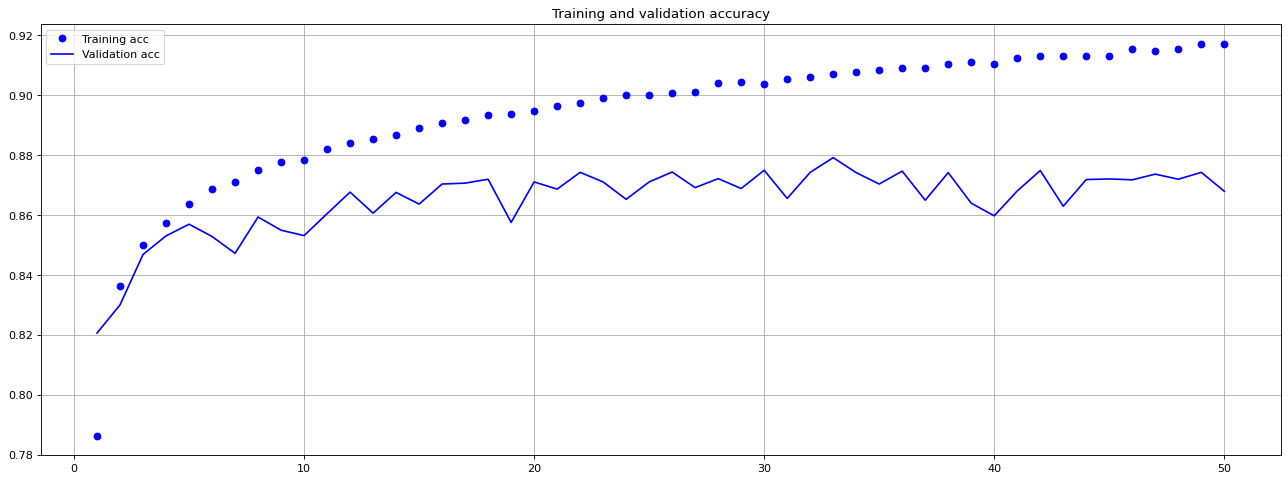

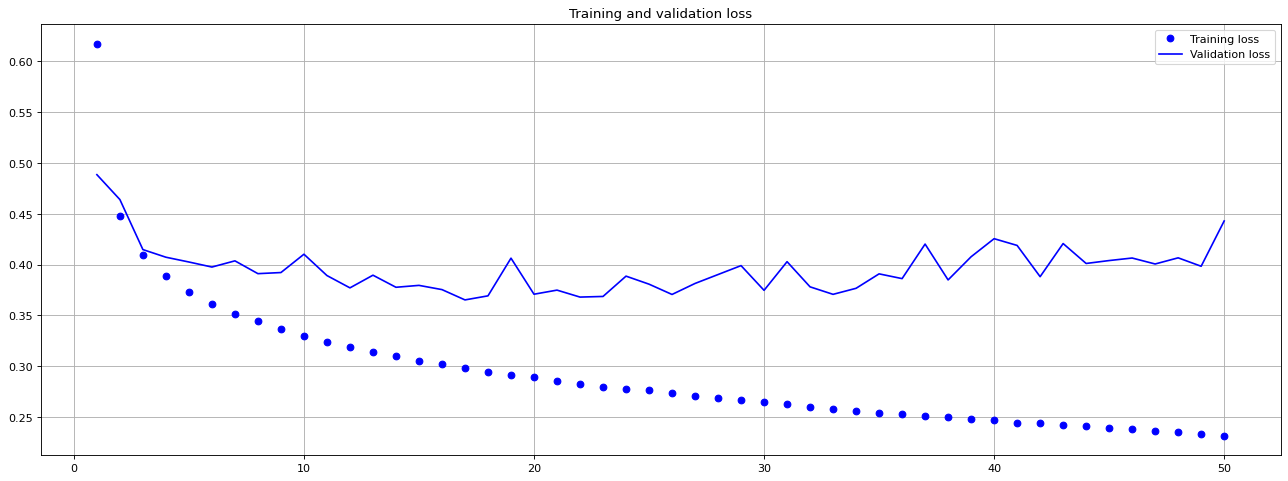

In [64]:
import matplotlib.pyplot as plt

acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(20, 7), dpi=80)
plt.grid(True)

plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")

plt.title("Training and validation accuracy")
plt.legend()

plt.figure(figsize=(20, 7), dpi=80)
plt.grid(True)

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")

plt.legend()
plt.show()


In [65]:
from keras.utils import plot_model
import matplotlib.image as mpimg

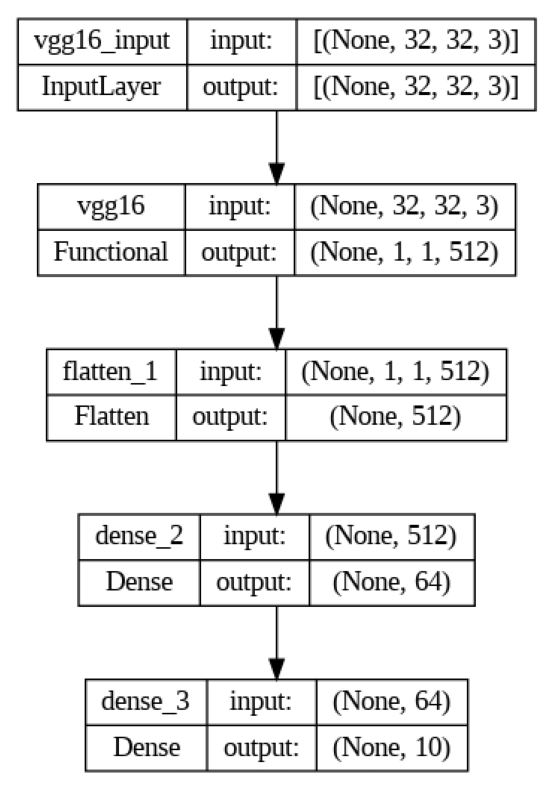

In [66]:
# Візуалізувати модель та зберегти її у файл
plot_model(model, to_file="/content/drive/MyDrive/files/model.png", show_shapes=True, show_layer_names=True)

# Завантажити та показати зображення моделі
img = mpimg.imread("/content/drive/MyDrive/files/model.png")
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off')
plt.show()

# Донавчання

Розглянемо інший прийом повторного використання моделі, який доповнює виділення ознак, саме донавчання. Цей підхід полягає в "розморожуванні" декількох верхніх шарів замороженої моделі, яка використовувалася для виділення ознак, і спільному навчанні нової доданої частини моделі (в даному випадку повнозв'язкового класифікатора) і цих верхніх шарів. Таким чином ми трохи коригуємо найбільш абстрактні уявлення в моделі, що повторно використовується, щоб зробити їх більш актуальними для даного завдання.

Звідси, власне, і походить така назва.

In [67]:
conv_base = VGG16(weights="imagenet", include_top=False, input_shape=(32, 32, 3))

In [68]:
n = 14
# Заморожуємо перші n шарів
for layer in conv_base.layers[:n]:
    layer.trainable = False
# Решта шарів залишаються тренувальними
for layer in conv_base.layers[n:]:
    layer.trainable = True

In [76]:
model_2 = models.Sequential([
   conv_base,
   layers.Flatten(),
   layers.Dense(64, activation="relu"),
   layers.Dense(10, activation="softmax"),
])

model_2.compile(
    loss='categorical_crossentropy',
    optimizer='rmsprop',
    metrics=["accuracy"]
)

In [77]:
model_2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_5 (Flatten)         (None, 512)               0         
                                                                 
 dense_10 (Dense)            (None, 64)                32832     
                                                                 
 dense_11 (Dense)            (None, 10)                650       
                                                                 
Total params: 14748170 (56.26 MB)
Trainable params: 7112906 (27.13 MB)
Non-trainable params: 7635264 (29.13 MB)
_________________________________________________________________


In [ ]:
# Візуалізувати модель та зберегти її у файл
plot_model(model_2, to_file="/content/drive/MyDrive/files/model_2_2.png", show_shapes=True, show_layer_names=True)

# Завантажити та показати зображення моделі
img = mpimg.imread("/content/drive/MyDrive/files/model_2_2.png")
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off')
plt.show()

Навчимо нашу модель з використанням даних Fashion MNIST.

In [78]:
history = model_2.fit(x_train_rgb, y_train, validation_data=(x_test_rgb, y_test), epochs=50, batch_size=64)

Epoch 1/50
938/938 [==============================] - 21s 21ms/step - loss: 0.2839 - accuracy: 0.9108 - val_loss: 0.3435 - val_accuracy: 0.9003
Epoch 2/50
938/938 [==============================] - 18s 20ms/step - loss: 0.2330 - accuracy: 0.9199 - val_loss: 0.4000 - val_accuracy: 0.8965
Epoch 3/50
938/938 [==============================] - 18s 20ms/step - loss: 0.2264 - accuracy: 0.9221 - val_loss: 0.4350 - val_accuracy: 0.8879
Epoch 4/50
938/938 [==============================] - 18s 19ms/step - loss: 0.2271 - accuracy: 0.9238 - val_loss: 0.3716 - val_accuracy: 0.8922
Epoch 5/50
938/938 [==============================] - 18s 20ms/step - loss: 0.2197 - accuracy: 0.9244 - val_loss: 0.3528 - val_accuracy: 0.8972
Epoch 6/50
938/938 [==============================] - 20s 21ms/step - loss: 0.2248 - accuracy: 0.9258 - val_loss: 0.4020 - val_accuracy: 0.9050
Epoch 7/50
938/938 [==============================] - 19s 20ms/step - loss: 0.2265 - accuracy: 0.9263 - val_loss: 0.4146 - val_accuracy:

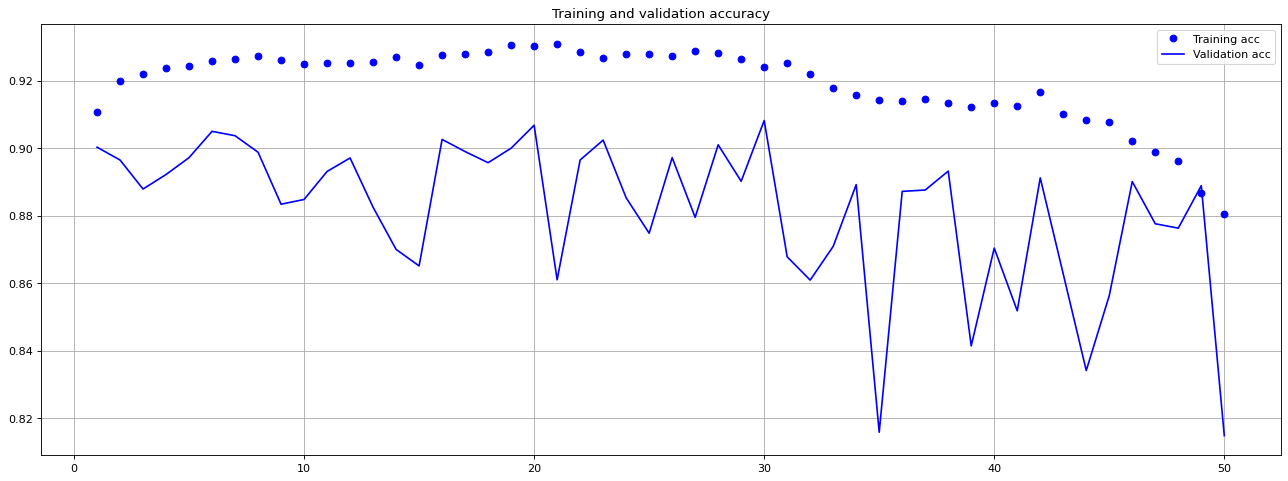

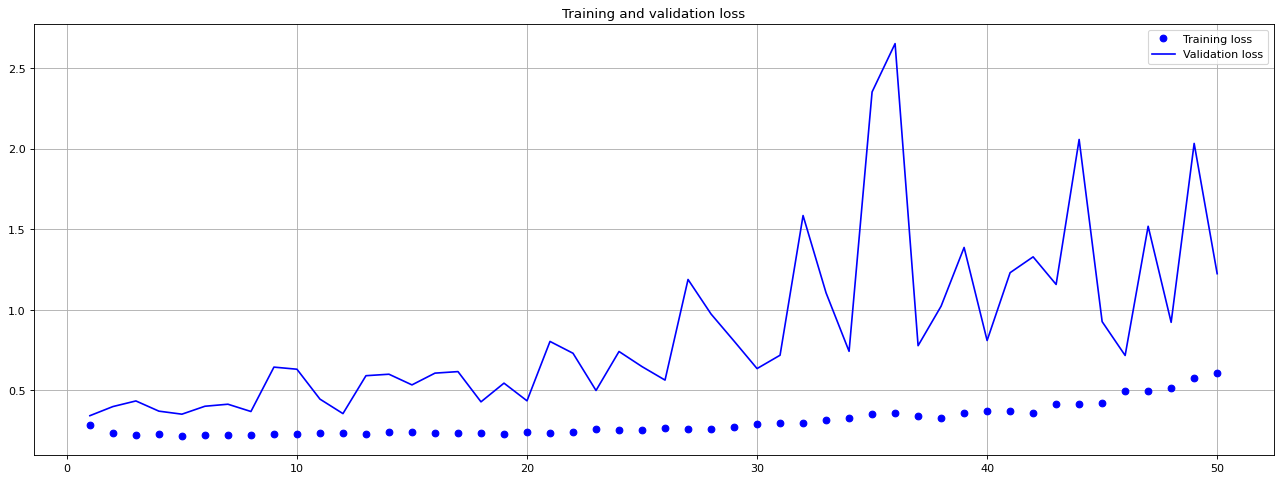

In [79]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(20, 7), dpi=80)
plt.grid(True)

plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")

plt.title("Training and validation accuracy")
plt.legend()

plt.figure(figsize=(20, 7), dpi=80)
plt.grid(True)

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")

plt.legend()
plt.show()

In [80]:
# Оцінка точності моделі
test_loss, test_acc = model_2.evaluate(x_test_rgb, y_test)
print(f'Test accuracy: {test_acc}')

313/313 [==============================] - 3s 8ms/step - loss: 1.2250 - accuracy: 0.8149
Test accuracy: 0.8148999810218811


In [81]:
from tensorflow.keras.callbacks import EarlyStopping

Спостерігаємо перенавчення моделі overfitting

In [85]:
model_3 = models.Sequential([
   conv_base,
   layers.Flatten(),
   layers.Dense(64, activation="relu"),
   layers.Dense(10, activation="softmax"),
])

model_3.compile(
    loss='categorical_crossentropy',
    optimizer='rmsprop',
    metrics=["accuracy"]
)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model_3.fit(
    x_train_rgb, y_train, validation_data=(x_test_rgb, y_test),
    epochs=40,
    batch_size=64,
    callbacks=[early_stopping]
)


Epoch 1/40
938/938 [==============================] - 58s 60ms/step - loss: 133.0404 - accuracy: 0.8198 - val_loss: 0.5859 - val_accuracy: 0.8837
Epoch 2/40
938/938 [==============================] - 20s 21ms/step - loss: 0.3475 - accuracy: 0.9028 - val_loss: 0.5714 - val_accuracy: 0.8840
Epoch 3/40
938/938 [==============================] - 20s 21ms/step - loss: 0.3436 - accuracy: 0.9067 - val_loss: 0.6653 - val_accuracy: 0.8889
Epoch 4/40
938/938 [==============================] - 18s 20ms/step - loss: 0.3700 - accuracy: 0.9039 - val_loss: 0.6677 - val_accuracy: 0.8757
Epoch 5/40
938/938 [==============================] - 20s 21ms/step - loss: 0.3790 - accuracy: 0.9051 - val_loss: 0.7802 - val_accuracy: 0.8965
Epoch 6/40
938/938 [==============================] - 19s 20ms/step - loss: 0.4515 - accuracy: 0.8988 - val_loss: 0.8740 - val_accuracy: 0.8826
Epoch 7/40
938/938 [==============================] - 20s 21ms/step - loss: 0.4425 - accuracy: 0.8903 - val_loss: 1.4732 - val_accurac

На графіку спостерігаємо перенавчання нашої моделі